In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import sys
import time
import logging  # [LOGGING] Importar la librería de logging
import random  # [SEED] Importar la librería random de Python
import numpy as np  # [SEED] Importar NumPy
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm  # Para barra de progreso

# Importar tu modelo corregido (asegúrate de que el archivo .py esté en la carpeta)
sys.path.append("KAN_models")
from SBTAYLOR_KAN import Net as KAN_Model

# Configuración de Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


# Semilla
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

Usando dispositivo: cuda


In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

# print("Path to dataset files:", path)

In [3]:
IMAGENET_PATH = "C:\\Users\\Admin-Cidis\\.cache\\kagglehub\\datasets\\akash2sharma\\tiny-imagenet\\versions\\1\\tiny-imagenet-200"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

RUN_SAVE_DIR = os.path.join("models/sbtaylor_kan_tiny_imagenet", f"run_{timestamp}")
os.makedirs(RUN_SAVE_DIR, exist_ok=True)

MODEL_NAME = "sbtaylor_kan.best_weights.pth"
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, MODEL_NAME)

In [4]:
LOG_FILE_PATH = os.path.join(RUN_SAVE_DIR, "training_run.log")

In [5]:
# --- [LOGGING] CONFIGURACIÓN DEL LOGGER ---
# Configura el logger para que escriba en un archivo y en la consola.
logging.basicConfig(
    level=logging.INFO,  # Nivel mínimo de mensajes a registrar (INFO, WARNING, ERROR)
    format="%(asctime)s - %(levelname)s - %(message)s",  # Formato del mensaje
    handlers=[
        logging.FileHandler(
            LOG_FILE_PATH, mode="w"
        ),  # Escribe en el archivo .log (modo 'w' para sobreescribir en cada ejecución)
        logging.StreamHandler(),  # Muestra los logs en la consola
    ],
)

# Ahora, en lugar de print(), usaremos logging.info()
logger = logging.getLogger()

logger.info("Modelo SBTAYLOR_KAN.Net importado correctamente.")
logger.info(f"Los pesos del modelo se guardarán en: '{MODEL_SAVE_PATH}'")
logger.info(f"El registro de entrenamiento se guardará en: '{LOG_FILE_PATH}'")

2026-01-04 16:05:30,517 - INFO - Modelo SBTAYLOR_KAN.Net importado correctamente.
2026-01-04 16:05:30,520 - INFO - Los pesos del modelo se guardarán en: 'models/sbtaylor_kan_tiny_imagenet\run_20260104_160530\sbtaylor_kan.best_weights.pth'
2026-01-04 16:05:30,523 - INFO - El registro de entrenamiento se guardará en: 'models/sbtaylor_kan_tiny_imagenet\run_20260104_160530\training_run.log'


In [6]:
logger.info(f"Versión de PyTorch: {torch.__version__}")
logger.info(f"¿CUDA está disponible?: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    logger.info(
        f"Versión de CUDA con la que PyTorch fue compilado: {torch.version.cuda}"
    )
    logger.info(f"Número de GPUs disponibles: {torch.cuda.device_count()}")
    logger.info(f"Nombre de la GPU actual: {torch.cuda.get_device_name(0)}")
else:
    logger.info(
        "PyTorch no puede encontrar CUDA. Es probable que hayas instalado la versión de solo CPU."
    )

2026-01-04 16:05:30,644 - INFO - Versión de PyTorch: 2.9.0+cu126
2026-01-04 16:05:30,648 - INFO - ¿CUDA está disponible?: True
2026-01-04 16:05:30,655 - INFO - Versión de CUDA con la que PyTorch fue compilado: 12.6
2026-01-04 16:05:30,659 - INFO - Número de GPUs disponibles: 1
2026-01-04 16:05:30,669 - INFO - Nombre de la GPU actual: NVIDIA GeForce RTX 4090


In [7]:
# --- 2. PARÁMETROS DE ENTRENAMIENTO ---
set_seed(74)  # [SEED] Establecer la semilla para reproducibilidad
BATCH_SIZE = 64
NUM_EPOCHS = 250
NUM_WORKERS = 4

# print hyperparameters
logging.info(f"--- Hyperparámetros de Entrenamiento ---")
logging.info(f"Batch Size: {BATCH_SIZE}")
logging.info(f"Num Epochs: {NUM_EPOCHS}")
logging.info(f"Num Workers: {NUM_WORKERS}")

2026-01-04 16:05:30,717 - INFO - --- Hyperparámetros de Entrenamiento ---
2026-01-04 16:05:30,719 - INFO - Batch Size: 64
2026-01-04 16:05:30,720 - INFO - Num Epochs: 250
2026-01-04 16:05:30,745 - INFO - Num Workers: 4


In [9]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, random_split, DataLoader, Dataset
import os

# --- 1. Clase Wrapper (Se mantiene igual) ---
class ApplyTransform(Dataset):
    """
    Envuelve un dataset (o subset) y aplica una transformación específica on-the-fly.
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)


# --- 2. Transformaciones ---

# TRAIN: Augmentations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    #crop
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# VAL: Estándar
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# TEST: Igual a Val (Sin augmentations, solo evaluar)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# --- 3. Carga y Filtrado ---
data_dir = IMAGENET_PATH + "/train" # Ajusta tu path si es necesario
print(f"Cargando datos desde: {data_dir}")

full_dataset_raw = torchvision.datasets.ImageFolder(data_dir)

# Seleccionamos solo las primeras 6 clases
selected_classes = full_dataset_raw.classes[:6]
print(f"Usando {len(selected_classes)} clases: {selected_classes}")

selected_indices = [i for i, (_, label) in enumerate(full_dataset_raw) if label < 6]
subset_dataset = Subset(full_dataset_raw, selected_indices)


# --- 4. Split 80/10/10 (Train/Val/Test) ---
total_len = len(subset_dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len  # El resto para test

# Ahora random_split recibe 3 longitudes
train_subset, val_subset, test_subset = random_split(
    subset_dataset, [train_len, val_len, test_len]
)


# --- 5. Aplicar Wrapper ---
# Asignamos transformaciones: Train con ruido, Val y Test limpias
train_dataset = ApplyTransform(train_subset, transform=transform_train)
val_dataset = ApplyTransform(val_subset, transform=transform_val)
test_dataset = ApplyTransform(test_subset, transform=transform_test)


# --- 6. DataLoaders ---
trainloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True
)
valloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)
testloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True
)

print(f"Dataset listo.")
print(f"Entrenamiento : {len(train_dataset)} imágenes")
print(f"Validación    : {len(val_dataset)} imágenes")
print(f"Test          : {len(test_dataset)} imágenes")

Cargando datos desde: C:\Users\Admin-Cidis\.cache\kagglehub\datasets\akash2sharma\tiny-imagenet\versions\1\tiny-imagenet-200/train
Usando 6 clases: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172']
Dataset listo.
Entrenamiento : 2400 imágenes
Validación    : 300 imágenes
Test          : 300 imágenes


In [10]:
# --- 4. INICIALIZACIÓN DEL MODELO, CRITERIO Y OPTIMIZADOR ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"\nUsando dispositivo: {device}")

2026-01-04 16:15:46,231 - INFO - 
Usando dispositivo: cuda


In [11]:
torch.autograd.set_detect_anomaly(True)

In [12]:
def model_init(learning_rate=0.001, dropout_1=0.4, dropout_2=0.5, weight_decay=1e-3):
    # Instanciar el modelo (Asegúrate que SBTAYLOR_KAN.Net es tu clase corregida)
    model_ft = KAN_Model(
        num_classes=len(selected_classes),
        input_size=(3, 224, 224),
        dropout_1=dropout_1,
        dropout_2=dropout_2,
    ).to(device)

    # En lugar de nn.CrossEntropyLoss() simple:
    criterion = nn.CrossEntropyLoss() #(label_smoothing=0.1)
    optimizer = optim.Adam(
        model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    return model_ft, criterion, optimizer

## Entrenamiento

In [13]:
import copy
import os
import torch
import time
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    output_dir,
    logger,
    scheduler=None,
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # --- CONFIGURACIÓN DE EARLY STOPPING ---
    patience = 50
    patience_counter = 0
    min_val_loss = np.inf
    early_stop = False
    # ---------------------------------------

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    logger.info(f"Iniciando entrenamiento por {num_epochs} épocas...")
    logger.info(f"Paciencia configurada: {patience} épocas.")

    for epoch in range(num_epochs):
        if early_stop:
            break

        logger.info(f"--- Época {epoch+1}/{num_epochs} ---")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloader, desc=f"{phase.capitalize()}", leave=False)

            for inputs, labels in loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())

                # ==========================================
                #      AQUÍ ESTÁ LA LÓGICA DEL SCHEDULER
                # ==========================================
                if scheduler is not None:
                    # ReduceLROnPlateau necesita el valor de la pérdida (loss)
                    scheduler.step(epoch_loss)

                    # Log para ver si el LR cambia
                    current_lr = optimizer.param_groups[0]["lr"]
                    logger.info(f"  [LR] Tasa de aprendizaje actual: {current_lr:.6f}")
                # ==========================================

                # --- LÓGICA DE EARLY STOPPING ---
                if epoch_loss < min_val_loss:
                    logger.info(
                        f"  [Mejora Loss] {min_val_loss:.4f} -> {epoch_loss:.4f}. Reseteando paciencia."
                    )
                    min_val_loss = epoch_loss
                    patience_counter = 0
                    best_model_wts = copy.deepcopy(model.state_dict())
                    save_path = os.path.join(output_dir, "best_model.pth")
                    torch.save(model.state_dict(), save_path)
                    logger.info(f"  [Nuevo Récord Loss] Guardado en: {save_path}")
                else:
                    patience_counter += 1
                    logger.info(
                        f"  [Sin mejora Loss] Paciencia: {patience_counter}/{patience}"
                    )
                    if patience_counter >= patience:
                        logger.info("¡EARLY STOPPING ACTIVADO!")
                        early_stop = True

            logger.info(
                f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}"
            )
                

    time_elapsed = time.time() - since
    logger.info(
        f"Entrenamiento finalizado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
    )
    logger.info(f"Mejor Val Loss lograda: {min_val_loss:.4f}")

    model.load_state_dict(best_model_wts)
    last_path = os.path.join(output_dir, "last_model.pth")
    torch.save(model.state_dict(), last_path)

    return model, history


# --- EJECUCIÓN ---

# Instanciar el modelo (Asegúrate que SBTAYLOR_KAN.Net es tu clase corregida)
# Nota: 'input_size' debe coincidir con el tamaño de tus imágenes en el dataloader
model_ft, criterion, optimizer = model_init()
#     best_params["lr"],
#     best_params["dropout_1"],
#     best_params["dropout_2"],
#     best_params["weight_decay"],
# )

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10,
    min_lr=1e-7
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150

# Llamar a entrenar pasando el scheduler
model_ft, history = train_model(
    model=model_ft,
    train_loader=trainloader,
    val_loader=valloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device,
    output_dir=RUN_SAVE_DIR,
    logger=logger,
    scheduler=scheduler,  # <--- Se pasa aquí
)

Dimensiones calculadas automáticamente para FC1: 25088


2026-01-04 16:15:48,037 - INFO - Iniciando entrenamiento por 250 épocas...
2026-01-04 16:15:48,038 - INFO - Paciencia configurada: 50 épocas.
2026-01-04 16:15:48,039 - INFO - --- Época 1/250 ---
2026-01-04 16:17:30,795 - INFO - Train Loss: 1.7915 Acc: 0.2467  
2026-01-04 16:17:33,919 - INFO -   [LR] Tasa de aprendizaje actual: 0.001000
2026-01-04 16:17:33,921 - INFO -   [Mejora Loss] inf -> 1.5710. Reseteando paciencia.
2026-01-04 16:17:34,448 - INFO -   [Nuevo Récord Loss] Guardado en: models/sbtaylor_kan_tiny_imagenet\run_20260104_160530\best_model.pth
2026-01-04 16:17:34,450 - INFO - Val Loss: 1.5710 Acc: 0.3300
2026-01-04 16:17:34,451 - INFO - --- Época 2/250 ---
2026-01-04 16:19:13,652 - INFO - Train Loss: 1.5885 Acc: 0.3321  
2026-01-04 16:19:15,912 - INFO -   [LR] Tasa de aprendizaje actual: 0.001000
2026-01-04 16:19:15,913 - INFO -   [Mejora Loss] 1.5710 -> 1.4811. Reseteando paciencia.
2026-01-04 16:19:16,706 - INFO -   [Nuevo Récord Loss] Guardado en: models/sbtaylor_kan_tiny

In [14]:
from torchsummary import summary

summary(model_ft, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56]         256
|    └─ReLU: 2-11                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 28, 28]         --
|   

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 14, 14]         --
|    └─Conv2d: 2-1                       [-1, 32, 224, 224]        896
|    └─BatchNorm2d: 2-2                  [-1, 32, 224, 224]        64
|    └─ReLU: 2-3                         [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 32, 112, 112]        --
|    └─Conv2d: 2-5                       [-1, 64, 112, 112]        18,496
|    └─BatchNorm2d: 2-6                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-7                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 64, 56, 56]          --
|    └─Conv2d: 2-9                       [-1, 128, 56, 56]         73,856
|    └─BatchNorm2d: 2-10                 [-1, 128, 56, 56]         256
|    └─ReLU: 2-11                        [-1, 128, 56, 56]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 28, 28]         --
|   

Gráfica guardada en: models/sbtaylor_kan_tiny_imagenet\run_20260104_160530\training_history.png


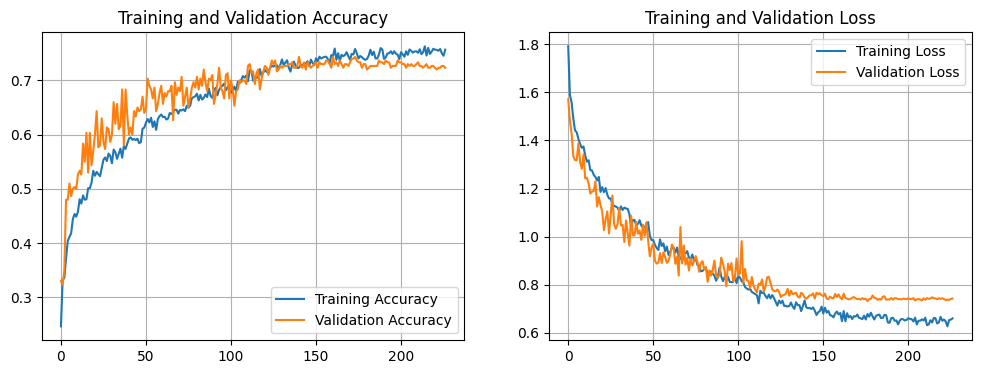

In [15]:
def plot_training_history(history):
    acc = history["train_acc"]
    val_acc = history["val_acc"]
    loss = history["train_loss"]
    val_loss = history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    # Gráfica de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")
    plt.grid(True)

    # Gráfica de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.grid(True)
    # --- CORRECCIÓN AQUÍ ---
    # 1. Guardar PRIMERO
    save_path = os.path.join(RUN_SAVE_DIR, "training_history.png")
    plt.savefig(
        save_path, dpi=300, bbox_inches="tight"
    )  # dpi=300 para alta calidad, bbox_inches corta bordes blancos extra
    print(f"Gráfica guardada en: {save_path}")

    # 2. Mostrar DESPUÉS
    plt.show()


plot_training_history(history)

In [16]:
import numpy as np
import time
import torch
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import logging  # Necesario para el type hinting o manejo interno


def evaluate_model(model, test_loader, device, class_names, output_dir, logger):
    """
    Evalúa un modelo entrenado y genera reporte.
    Ahora recibe 'logger' como argumento para asegurar que escriba en tu archivo .log.
    """
    logger.info("\n" + "=" * 40)
    logger.info("--- INICIANDO EVALUACIÓN EN TEST SET ---")
    logger.info("=" * 40)

    # 1. Poner el modelo en modo de evaluación (Apaga Dropout/BatchNorm)
    model.eval()

    all_labels = []
    all_preds = []

    total_inference_time = 0.0
    total_samples = 0

    # 2. Iterar sobre el conjunto de prueba
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # --- BLOQUE DE MEDICIÓN DE TIEMPO PRECISA ---
            # Si usas GPU, es obligatorio sincronizar antes y después del forward
            if device.type == "cuda":
                torch.cuda.synchronize()

            start_time = time.time()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            if device.type == "cuda":
                torch.cuda.synchronize()

            end_time = time.time()
            # ---------------------------------------------

            # Acumular tiempo real de procesamiento
            total_inference_time += end_time - start_time
            total_samples += inputs.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Convertir a numpy
    true_labels = np.array(all_labels)
    predicted_labels = np.array(all_preds)

    # 3. Calcular Métricas
    logger.info("Calculando métricas estadísticas...")

    accuracy = accuracy_score(true_labels, predicted_labels)

    # zero_division=0 evita errores si una clase no tiene predicciones
    precision_per_class = precision_score(
        true_labels, predicted_labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        true_labels, predicted_labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        true_labels, predicted_labels, average=None, zero_division=0
    )

    # Promedios Macro (trata todas las clases igual, útil si hay desbalance)
    avg_precision = np.mean(precision_per_class)
    avg_recall = np.mean(recall_per_class)
    avg_f1 = np.mean(f1_per_class)

    # Tiempo promedio por imagen (Métrica Clave para KAN vs VGG)
    avg_inference_time_ms = (total_inference_time / total_samples) * 1000

    # 4. Matriz de Confusión Visual
    logger.info("Generando matriz de confusión...")
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",  # 'd' es para enteros (decimal), mejor que 'g' para conteos
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicción del Modelo", fontsize=12)
    plt.ylabel("Realidad (Ground Truth)", fontsize=12)
    plt.title(f"Matriz de Confusión - Accuracy: {accuracy:.2%}", fontsize=14)

    cm_path = os.path.join(output_dir, "confusion_matrix.png")
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.close()  # Cierra la figura para liberar memoria
    logger.info(f"Gráfico guardado en: {cm_path}")

    # 5. Reporte de Texto
    logger.info("Escribiendo reporte final...")

    metrics_df = pd.DataFrame(
        {
            "Clase": class_names,
            "Precision": np.round(precision_per_class, 4),
            "Recall": np.round(recall_per_class, 4),
            "F1-Score": np.round(f1_per_class, 4),
        }
    )

    report_path = os.path.join(output_dir, "test_metrics_report.txt")

    with open(report_path, "w", encoding="utf-8") as f:
        f.write("=" * 50 + "\n")
        f.write(f" REPORTE DE EVALUACIÓN: {time.strftime('%Y-%m-%d %H:%M')}\n")
        f.write("=" * 50 + "\n\n")

        f.write(f"Métricas Globales:\n")
        f.write(f"- Accuracy:          {accuracy:.4f} ({accuracy:.2%})\n")
        f.write(f"- Macro Precision:   {avg_precision:.4f}\n")
        f.write(f"- Macro Recall:      {avg_recall:.4f}\n")
        f.write(f"- Macro F1-Score:    {avg_f1:.4f}\n\n")

        f.write("-" * 30 + "\n")
        f.write("EFICIENCIA (Velocidad)\n")
        f.write("-" * 30 + "\n")
        f.write(f"- Muestras totales:  {total_samples}\n")
        f.write(f"- Tiempo total:      {total_inference_time:.4f} seg\n")
        f.write(f"- Tiempo por imagen: {avg_inference_time_ms:.4f} ms\n\n")

        f.write("-" * 30 + "\n")
        f.write("DETALLE POR CLASE\n")
        f.write("-" * 30 + "\n")
        # Usamos to_markdown si pandas es reciente, sino to_string
        try:
            f.write(metrics_df.to_markdown(index=False))
        except:
            f.write(metrics_df.to_string(index=False))

        f.write("\n\n")
        f.write("Matriz de Confusión (Texto):\n")
        f.write(np.array2string(cm, separator=", "))

    logger.info(f"Reporte de texto guardado en: {report_path}")
    logger.info("--- EVALUACIÓN FINALIZADA ---")

    return (
        accuracy,
        avg_f1,
    )  # Retorna valores por si los necesitas en el script principal

In [17]:
MODEL_SAVE_PATH = os.path.join(RUN_SAVE_DIR, "best_model.pth")
# 2. Crear una nueva instancia del modelo y cargar los mejores pesos
logger.info("Cargando el mejor modelo para la evaluación...")
eval_model = KAN_Model(num_classes=len(selected_classes), input_size=(3, 224, 224)).to(
    device
)
eval_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
class_names = (
    selected_classes  # Obtener los nombres de las clases desde el dataset de prueba
)
class_names

2026-01-04 20:02:18,705 - INFO - Cargando el mejor modelo para la evaluación...


Dimensiones calculadas automáticamente para FC1: 25088


['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172']

In [18]:
# 3. Llamar a la función de evaluación
# Suponiendo que tienes un 'test_loader' y un 'RUN_DIR' definidos
evaluate_model(
    model=eval_model,
    test_loader=testloader,  # Usando val_loader como ejemplo; reemplaza con test_loader si tienes uno
    device=device,
    class_names=class_names,
    output_dir=RUN_SAVE_DIR,  # El directorio de la ejecución actual para guardar los resultados
    logger=logger,
)

2026-01-04 20:02:20,059 - INFO - 
2026-01-04 20:02:20,060 - INFO - --- INICIANDO EVALUACIÓN EN TEST SET ---
2026-01-04 20:02:20,061 - INFO - ========================================
2026-01-04 20:02:23,682 - INFO - Calculando métricas estadísticas...
2026-01-04 20:02:23,692 - INFO - Generando matriz de confusión...
2026-01-04 20:02:24,602 - INFO - Gráfico guardado en: models/sbtaylor_kan_tiny_imagenet\run_20260104_160530\confusion_matrix.png
2026-01-04 20:02:24,605 - INFO - Escribiendo reporte final...
2026-01-04 20:02:24,617 - INFO - Reporte de texto guardado en: models/sbtaylor_kan_tiny_imagenet\run_20260104_160530\test_metrics_report.txt
2026-01-04 20:02:24,619 - INFO - --- EVALUACIÓN FINALIZADA ---


(0.7366666666666667, np.float64(0.728358244358842))